# Lab: Style Transfer

By: Lawrence (Jake) Klinkert and Hongjin (Tony) Yu

CS8321 Sect 001 1222

3/27/2022

Submission Details: Turn in the rendered jupyter notebook (exported as HTML) to canvas. Only one notebook per team is required, but team names must be on the assignment.

If using code from another author (not your own), you will be graded on the clarity of explanatory comments you add to the code. 

In [1]:
from PIL import Image
import requests

In this lab you will implement a style transfer algorithm with whitening and coloring transformations, using the work of Li et al. in their universal style transfer paper. An example implementation of training a decoder for different scales of VGG has been implemented for you to build from (https://github.com/8000net/universal-style-transfer-keras to an external site.). However, you will be manipulating the code to work properly. Also, the code should be updated to work with the newest version of Keras/Tensorflow. As always, you can choose a PyTorch implementation if you prefer.

[2 Points] Look at the above decoder code and describe any errors (or imperfections) in the upsampling layers. Discuss how these errors could be fixed. Now implement these solutions either by updating the code or rewriting the implementation. Remember that you should use strided convolutions without any pooling steps (i.e., do NOT use unpooling). You can also use another network besides VGG if you desire (such as UNET, for example). If using a new network, be sure it uses only feedforward connections (for simplicity). 

#### Original Code to refrence

In [1]:
from keras.layers import Input, Conv2D, UpSampling2D

def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x

    x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

    x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 4:
        return x

    x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 5:
        return x

#### Architecture of encoder-decoder convolutional neural network for Vgg19

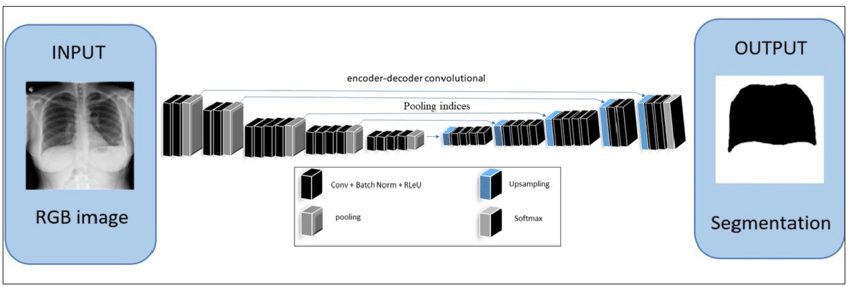

In [2]:
Image.open(requests.get("https://www.researchgate.net/publication/343048987/figure/fig1/AS:915587807051776@1595304552999/Architecture-of-encoder-decoder-convolutional-neural-network-prepared-by-Vgg19-model.png", stream=True).raw)

Image of VGG19 encoder-decoder architecture. proovided by Shadeed et al.

G. Shadeed, M. Tawfeeq, and S. Mahmoud, “Automatic Medical Images Segmentation Based on Deep Learning Networks,” IOP Conference Series: Materials Science and Engineering, vol. 870, p. 012117, Jul. 2020, doi: 10.1088/1757-899X/870/1/012117.

#### Errors and Imperfections

From the above code and figure created by Shadeed et al. showing the architecture of VGG19, we can determine the correct structure of the decoder. For Major errors with the code, the decoder is not a reflection of the encoder. For start, VGG19 enocder will flatten the image, and we will need to input the each block is decreasing in size when we should be increasing, due to the upsampling. Second, the number of convolutional layers per block are wrong, it should be 4, 4, 4, 2, 2. Finally, a minor issue is that if the user does not provide a layer that is between 1 and 5, then the model will not return anything.

#### Refactor

In [3]:
from keras.layers import Input, Conv2D, UpSampling2D

def decoder_layers(inputs, layer):
    x = UpSampling2D((2, 2), name='decode_block5_upsample')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decode_block5_conv4')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decode_block5_conv3')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decode_block5_conv2')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decode_block5_conv1')(inputs)
    if layer == 5:
        return x

    x = UpSampling2D((2, 2), name='decode_block4_upsample')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decode_block4_conv4')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decode_block4_conv3')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decode_block4_conv1')(x)
    if layer == 4:
        return x

    x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decode_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decode_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decode_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decode_block3_conv1')(x)
    if layer == 3:
        return x

    x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decode_block2_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decode_block2_conv1')(x)
    if layer == 2:
        return x

    #x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decode_block1_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decode_block1_conv1')(x)
    # if layer == 1
    return x

[5 Points] Train two (or more) image decoders that can decode an image from two different convolutional layers from VGG (or whatever network you want).  You should choose one reconstruction from an early layer (like block 1 or 2 in VGG) and from a later layer (like block 3 or later in VGG).

If using Keras, there is starter code available at the link above. You may use any image dataset you like for training. One nice option might be the labeled faces in the wild dataset, available in scikit-learn. This is a modest sized dataset, but is only of faces, which can help speed along training because of the reduced variability. 

For the loss function, be sure to use both the L2 loss of the reconstructed image and the encoder representation (i.e., image loss and feature loss).
 

Plot both training and validation losses versus the number of epochs to show that the training has converged. 


Note, decoding training can be sped up significantly by manipulating the above code to train multiple decoders in the same pass.


If your auto encoder fails to converge, you may use pre-trained image decoder weights (from anywhere online). Be sure to cite any code or weights you use properly. For example, you can use the pre-trained auto encoder from class: 
<ul>
<li> https://github.com/8000net/LectureNotesMaster/blob/master/03c%20UniversalStyleTransfer.ipynbLinks to an external site. </li>
<li> Model Weights (large files!!): https://www.dropbox.com/sh/2djb2c0ohxtvy2t/AAAxA2dnoFBcHGqfP0zLx-Oua?dl=0Links to an external site. 
<li> A slightly reduced grade will be given for using pre-trained encoder/decoder pairs. However, it is better to use an existing implementation rather than an implementation that failed to converge. </li>
<li> The GitHub link from Yihao Wang, who wrote this implementation: https://github.smu.edu/48066464/CS8321Lab2_DecoderLinks to an external site. </li>
</ul>

[1 Points] Show a few images and their reconstructions using each decoder. Comment on any artifacts from the images. For full credit, the decoding of the images should look similar and the performance should be discussed. 

[1 Points] Implement the whitening and coloring transform (WCT) as described by Li et al. An implementation of this has already been written for you, available in the link above and in the class master repository.  You should use an SVD decomposition of the covariance (NOT an SVD of the activations). 

Show a few images that are style transferred using this method and describe their quality.  

Implement three of following additions to the style network. You may choose any three from this list. Each implementation is worth 2 points. Doing more than three will not result in extra credit. Only the first three implementations in your notebook will be graded. You should describe the results of each style transfer implementation in detail to receive full credit. 

<ul>
<li> [2 points] Implement the smoothing constraint from Li et al. to achieve more photo realistic style transfer results. Show a few photo-realistic style changes from the network. </li>
<li> [2 points] Perform style transfer with an image mask, where each segmented portion of the image is given a different style. Show a few images with multiple styles applied to the different segmented patches. </li>
<li> [2 points] Implement a different covariance matching algorithm. You can use any covariance matching algorithm you want. For example, see the discussion here: https://openaccess.thecvf.com/content_ICCV_2019/papers/Lu_A_Closed-Form_Solution_to_Universal_Style_Transfer_ICCV_2019_paper.pdfLinks to an external site. </li>
<li> [2 points] When using multiple style images, manipulate the decoder to blend different styles in the reconstruction. That is, use the methods from Li et al. in reconstructing from multiple style images by linearly blending the different outputs from each style-decoded image.</li>
<li> [2 points] Implement a color preserving style transfer. That is, manipulate the content image to be in HSV space, then style the V channel only. Combine back with the H and S channels using appropriate blurring. Show a few images with and without color preservations to verify that color is preserved better.</li>
<li> [2 points] Implement a style transfer addition of your choosing (or something from the literature). If selecting this option, reach out to the instructor to be sure the addition is of sufficient complexity.  </li>
</ul>